In [1]:
import os
import sys
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score, auc, precision_recall_curve
from sklearn.metrics import average_precision_score

np.random.seed(2019)

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import lightgbm as lgb

In [2]:
base_path = os.path.abspath('../..')
data_path = os.path.join(base_path, 'data')
database_path = os.path.join(data_path, 'database')
strategy_path = os.path.join(base_path, 'strategy')
sys.path.append(strategy_path)

In [3]:
from strategy import CommodityStrategy, EquityStrategy, IRStrategy, EmergingStrategy
from tester import Tester

In [4]:
from models.CRNN import CRNN_model

# 1. Data

In [5]:
strategy = EquityStrategy(strategy_name="EPM", asset_type="EQUITY")
strategy.load_index_and_return(from_db=False, save_file=False)

strategy.index.columns.name = 'ticker'
strategy.ret.columns.name = 'ticker'

strategy.index.index.name = 'tdate'
strategy.ret.index.name = 'tdate'

strategy.index.drop_duplicates(inplace=True)
strategy.ret.drop_duplicates(inplace=True)

strategy.ret.loc['2005-02-16'] = strategy.ret.loc['2005-02-17']

df_index = strategy.index.loc[:'2019-07']
df_index_return = strategy.ret.loc[:'2019-07']

2019-10-31 14:19:56,484 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-31 14:19:56,487 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-31 14:19:56,488 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


# 2. Explore

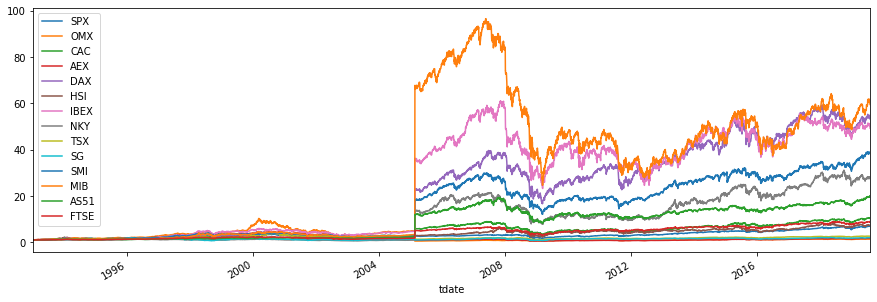

In [6]:
plt.figure(figsize=(15,5))
for column in df_index.columns:
    df_index[column].plot()
plt.legend()

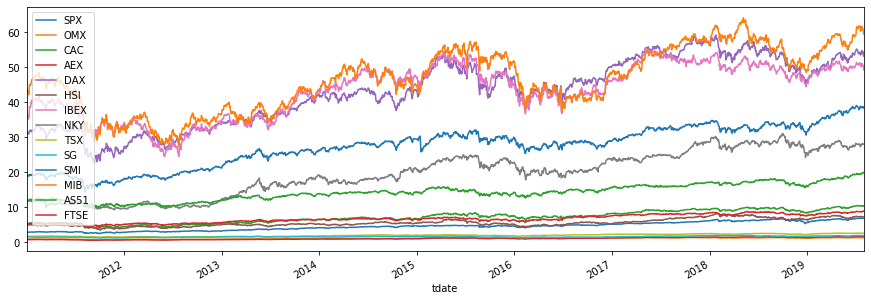

In [7]:
plt.figure(figsize=(15,5))
for column in df_index.columns:
    df_index.loc['2011':][column].plot()
plt.legend()

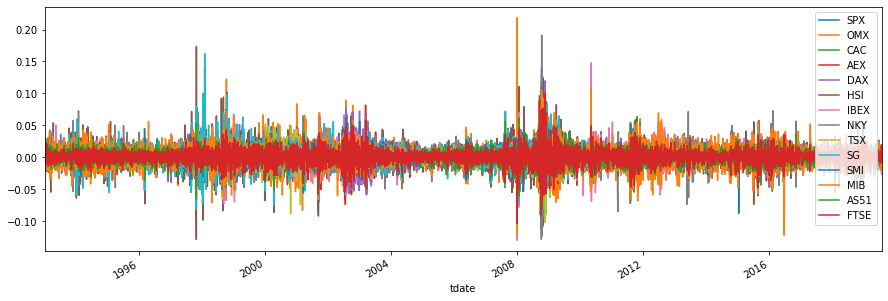

In [8]:
plt.figure(figsize=(15,5))
for column in df_index_return.columns:
    df_index_return[column].plot()
plt.legend()

# 3. Model

### CROSS SECTIONAL

In [9]:
indiv_momentum_lst = [1, 2, 3, 4, 5, 10, 21, 42, 63]

## 1. X

### moving average 와 주가 차이

In [10]:
moving_avg = {}

for i, period in enumerate(indiv_momentum_lst):
    moving_avg['moving_average_' + str(period)] = df_index.rolling(period).mean() - df_index

### moving average  ratio

In [11]:
moving_avg_ratio = {}
moving_avg_ratio_diff = {}

for i, period in enumerate(indiv_momentum_lst):
    moving_avg_ratio['moving_average_ratio_' + str(period)] = df_index.rolling(period).mean() / df_index
    moving_avg_ratio_diff['moving_average_ratio_diff_' + str(period)] = moving_avg_ratio['moving_average_ratio_' + str(period)].diff(period)

In [12]:
df_moving_avg = pd.concat(moving_avg, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]
df_moving_avg_ratio = pd.concat(moving_avg_ratio, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]
df_moving_avg_ratio_diff = pd.concat(moving_avg_ratio_diff, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]

### moving average ratio 간 차이

In [13]:
moving_avg_columns = df_moving_avg_ratio.columns

for i, column1 in enumerate(moving_avg_columns[1:]):
    for j, column2 in enumerate(moving_avg_columns[2+i:]):
        df_moving_avg_ratio[column2 + " - " + column1] = df_moving_avg_ratio[column1] - df_moving_avg_ratio[column2]

# CASE 0. 기존

<img src="./result/EPM_PAST.png">

<img src="./result/EPM.png">

- 빨간색이 CROSS SECTIONAL 임

# CASE 1. BINARY

- Binary로 나누어서 학습하고 상위 30% 하위 30% 롱숏

In [14]:
one_week = 5
one_month = 20

In [15]:
df_index_rank = df_index.pct_change(one_week).shift(-1 * one_week).rank(axis=1) 

### binary - 50%

In [16]:
df_index_y_binary = df_index_rank > df_index_rank.shape[1] / 2
df_index_y_binary = df_index_y_binary.astype(np.float32)

In [17]:
df_y = df_index_y_binary.unstack().reset_index()
df_y = df_y.set_index('tdate').loc['1994':]
df_y.columns = ['ticker', 'y']

In [18]:
df_moving_avg.reset_index(inplace=True)
df_moving_avg_ratio.reset_index(inplace=True)

df_join = pd.merge(df_y, df_moving_avg, on=['tdate', 'ticker'])
df_join = pd.merge(df_join, df_moving_avg_ratio, on=['tdate', 'ticker'])
df_join = pd.merge(df_join, df_moving_avg_ratio_diff, on=['tdate', 'ticker'])

In [19]:
df_train = df_join.loc[df_join['tdate'] <= pd.to_datetime('2010-12-31')]
df_val = df_join.loc[(df_join['tdate'] >= pd.to_datetime('2009-01-01')) & (df_join['tdate'] <= pd.to_datetime('2010-12-31'))]
df_test = df_join.loc[df_join['tdate'] >= pd.to_datetime('2011-01-01')]

df_train_y = df_train['y']
df_train_x = df_train[df_train.columns[3:]]

df_val_y = df_val['y']
df_val_x = df_val[df_val.columns[3:]]

df_test_y = df_test['y']
df_test_x = df_test[df_test.columns[3:]]

In [20]:
def train(train_x, train_y1, val_x, val_y1, num_boost_round=1000, learning_rate=0.01, early_stopping_rounds=50, verbose=None):
    params1 = {"objective": "binary",
          "boosting_type": "gbdt",
          "num_boost_round": num_boost_round,
          'max_depth': 3,
          'num_leaves': 25,
          "learning_rate": learning_rate,
          "feature_fraction": 0.8,
          "subsample": 0.8,
          "verbosity": 1,
          "metric": 'binary_logloss'
          }              
    
    train_data = lgb.Dataset(train_x, train_y1)
    val_data = lgb.Dataset(val_x, val_y1)
    lgb_model = lgb.train(train_set=train_data, params=params1, early_stopping_rounds=early_stopping_rounds,
                          valid_sets=[train_data, val_data], verbose_eval=verbose)
    
    train_pred = lgb_model.predict(train_x)
    val_pred = lgb_model.predict(val_x)
    return lgb_model, train_pred, val_pred

In [21]:
lgb_models = []
lgb_train_pred1 = []
lgb_val_pred1 = []

model, train_pred, val_pred = train(df_train_x.values, df_train_y.values, df_train_x.values, df_train_y.values, 
                                    num_boost_round=500, 
                                    learning_rate=0.01, 
                                    verbose=10,
                                    early_stopping_rounds=500)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.692719	valid_1's binary_logloss: 0.692719
[20]	training's binary_logloss: 0.692355	valid_1's binary_logloss: 0.692355
[30]	training's binary_logloss: 0.692039	valid_1's binary_logloss: 0.692039
[40]	training's binary_logloss: 0.691747	valid_1's binary_logloss: 0.691747
[50]	training's binary_logloss: 0.691478	valid_1's binary_logloss: 0.691478
[60]	training's binary_logloss: 0.691226	valid_1's binary_logloss: 0.691226
[70]	training's binary_logloss: 0.691003	valid_1's binary_logloss: 0.691003
[80]	training's binary_logloss: 0.690788	valid_1's binary_logloss: 0.690788
[90]	training's binary_logloss: 0.690596	valid_1's binary_logloss: 0.690596
[100]	training's binary_logloss: 0.690414	valid_1's binary_logloss: 0.690414
[110]	training's binary_logloss: 0.690236	valid_1's binary_logloss: 0.690236
[120]	training's binary_logloss: 0.690077	valid_1's binary_logloss: 0.690077
[130]	training's binary

In [22]:
test_pred = model.predict(df_test_x.values)

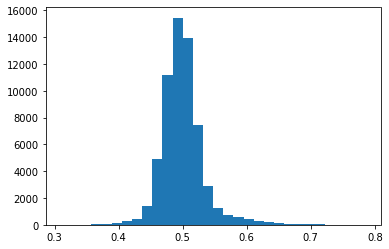

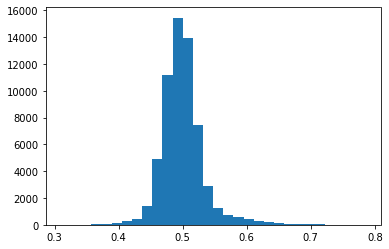

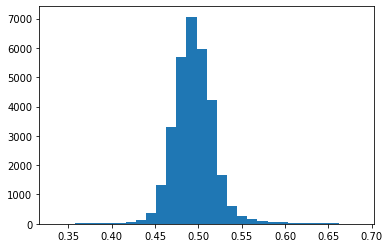

In [23]:
plt.hist(train_pred, bins=30)
plt.show()

plt.hist(val_pred, bins=30)
plt.show()

plt.hist(test_pred, bins=30)
plt.show()

### 결과

In [24]:
df_train['y_pred'] = train_pred
df_test['y_pred'] = test_pred

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [25]:
df_train_pred = pd.pivot_table(df_train, columns='ticker', index='tdate', values='y_pred')
df_test_pred = pd.pivot_table(df_test, columns='ticker', index='tdate', values='y_pred')

In [26]:
df_pred = pd.concat([df_train_pred, df_test_pred], axis=0)

In [27]:
df_index_sub = df_index.loc['1994':]

In [28]:
long = df_pred.shape[1] / 10 * 7
short = df_pred.shape[1] / 10 * 3

df_pred_rank = df_pred.rank(axis=1)
df_pred_long = (df_pred_rank > long).astype(np.float32)
df_pred_short = (df_pred_rank < short).astype(np.float32)
df_pred_long_short = df_pred_long - df_pred_short

In [29]:
strategy.TSRV = df_pred_long_short
strategy.CSRV = df_pred_long_short

In [30]:
strategy.set_rebalance_period(freq='week', rebalance_weekday=1) 

2019-10-31 14:20:05,211 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD


In [32]:
tester = Tester(strategy)

In [33]:
tsrv_cum_return, tsrv_summary = tester.test_ts_signal()
csrv_cum_return, csrv_summary = tester.test_cs_signal()

C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:29: RuntimeWarning: divide by zero encountered in true_divide
  tsrv_port = pd.DataFrame(tsrv_sig.to_numpy() / tsrv_sig.sum(axis=1).values.reshape(-1, 1), columns=tsrv_sig.columns, index=tsrv_sig.index)
C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:29: RuntimeWarning: invalid value encountered in true_divide
  tsrv_port = pd.DataFrame(tsrv_sig.to_numpy() / tsrv_sig.sum(axis=1).values.reshape(-1, 1), columns=tsrv_sig.columns, index=tsrv_sig.index)
C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:39: RuntimeWarning: divide by zero encountered in true_divide
  csrv_port = pd.DataFrame(csrv_sig.to_numpy() / csrv_sig.sum(axis=1).values.reshape(-1, 1), columns=csrv_sig.columns, index=csrv_sig.index)
C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:39: RuntimeWarning: invalid value encountered in

In [34]:
strategy.set_portfolio_parameter(cs_strategy_type='notional')
strategy.make_portfolio()

2019-10-31 14:20:11,795 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 14:20:11,795 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 14:20:11,796 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-31 14:20:25,455 - EPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-31 14:20:25,455 - EPM - INFO - [STEP 5 - 2 - 1] ALIGN TS POSITION WITH REBALANCE DAY
2019-10-31 14:20:27,049 - EPM - INFO - [STEP 5 - 2 - 2] TARGET VOL CONTROL to TS POSITION
2019-10-31 14:20:27,056 - EPM - INFO - [STEP 5 - 2 - 3] STRATEGY LEVEL VOL CONTROL to TS POSITION
2019-10-31 14:20:28,140 - EPM - INFO - [STEP 5 - 2 - 4] MAKE FINAL TS POSITION
2019-10-31 14:20:28,143 - EPM - INFO - [STEP 5 - 3] MAKE CS POSITION
2019-10-31 14:20:28,143 - EPM - INFO - [STEP 5 - 3 - 1] NO TARGET VOL CONTROL to CS POSITION
2019-10-31 14:20:28,144 - EPM - INFO - [STEP 5 - 3 - 2] ALIGN CS POSITION WITH REBALANCE DAY
2019-10-31 14:20:36,274 - EPM - INFO - [STEP 5 - 3 - 3] STRATEGY LEVEL VOL CONTROL to CS POSITION
2019-10-31

### TRAIN

2019-10-31 08:58:50,393 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-31 08:58:50,394 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-31 08:58:50,407 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-31 08:58:50,419 - EPM - INFO - [STEP 7] PLOT BACKTEST RESULT


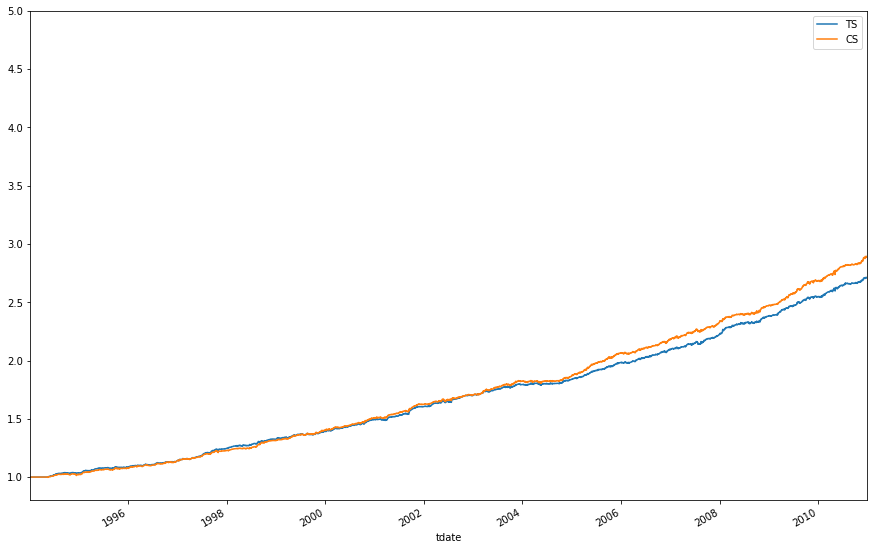

In [34]:
tester = Tester(strategy)
tester.set_period(start='1994-01-01', end='2010-12-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.8, 5))

### TEST

2019-10-31 14:20:55,810 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-31 14:20:55,811 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-31 14:20:55,820 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-31 14:20:55,828 - EPM - INFO - [STEP 7] PLOT BACKTEST RESULT


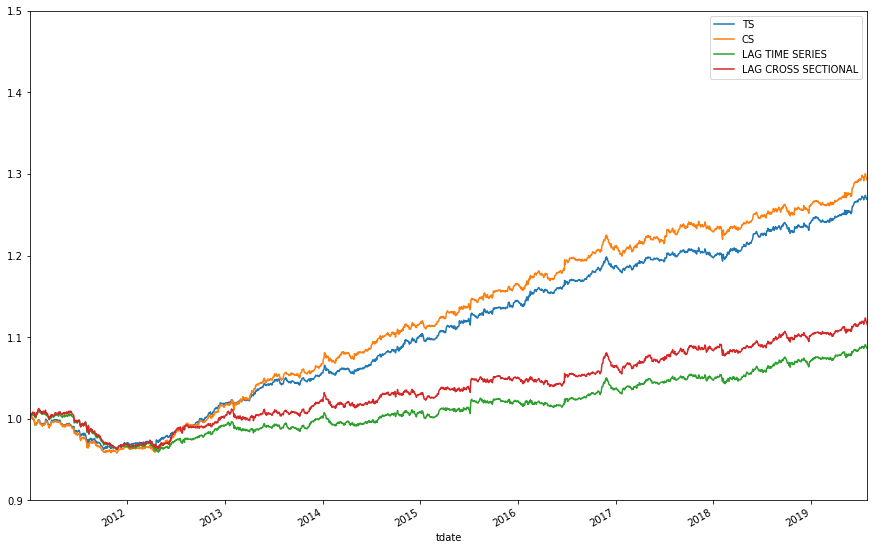

In [35]:
tester = Tester(strategy)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False,  ylim=(0.9, 1.5), include_lag=True)

# CASE 2. BINARY 30% 70%


- 상위 30%에 속하는 데이터와 하위 30%에 속하는 데이터로 학습한다.

In [36]:
one_week = 5
one_month = 20

df_index_rank = df_index.pct_change(one_week).shift(-1 * one_week).rank(axis=1) 

df_index_y_binary30_1 = df_index_rank > 7/10 * df_index_rank.shape[1]
df_index_y_binary30_1 = df_index_y_binary30_1.astype(np.float32)

df_index_y_binary30_2 = df_index_rank < 3/10 * df_index_rank.shape[1]
df_index_y_binary30_2 = df_index_y_binary30_2.astype(np.float32)

In [37]:
df_index_y_binary30_1 = df_index_y_binary30_1.unstack().reset_index()
df_index_y_binary30_1.columns = ['ticker', 'tdate', 'info']

df_index_y_binary30_2 = df_index_y_binary30_2.unstack().reset_index()
df_index_y_binary30_2.columns = ['ticker', 'tdate', 'info']

In [38]:
df_index_y_binary30_1 = df_index_y_binary30_1[df_index_y_binary30_1['info'] == 1]
df_index_y_binary30_2 = df_index_y_binary30_2[df_index_y_binary30_2['info'] == 1]
df_index_y_binary30 = pd.concat([df_index_y_binary30_1, df_index_y_binary30_2], axis=0)

In [39]:
df_y2 = df_index_y_binary.unstack().reset_index()
df_y2.columns = ['ticker', 'tdate', 'y']
df_y2 = pd.merge(df_y2, df_index_y_binary30, on=['ticker', 'tdate'])

In [40]:
df_join2 = pd.merge(df_y2, df_moving_avg, on=['tdate', 'ticker'])
df_join2 = pd.merge(df_join2, df_moving_avg_ratio, on=['tdate', 'ticker'])
df_join2 = pd.merge(df_join2, df_moving_avg_ratio_diff, on=['tdate', 'ticker'])

In [41]:
df_train = df_join2.loc[df_join2['tdate'] <= pd.to_datetime('2010-12-31')]
df_val = df_join.loc[(df_join['tdate'] >= pd.to_datetime('2009-01-01')) & (df_join2['tdate'] <= pd.to_datetime('2010-12-31'))]
df_test = df_join.loc[df_join['tdate'] >= pd.to_datetime('2011-01-01')]

df_train_y = df_train['y']
df_train_x = df_train[df_train.columns[4:]]

df_val_y = df_val['y']
df_val_x = df_val[df_val.columns[3:]]

df_test_y = df_test['y']
df_test_x = df_test[df_test.columns[3:]]

In [42]:
model2, train_pred2, val_pred2 = train(df_train_x.values, df_train_y.values, df_val_x.values, df_val_y.values, 
                                    num_boost_round=500, 
                                    learning_rate=0.01, 
                                    verbose=10,
                                    early_stopping_rounds=500)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.68621	valid_1's binary_logloss: 0.697362
[20]	training's binary_logloss: 0.685542	valid_1's binary_logloss: 0.696915
[30]	training's binary_logloss: 0.684965	valid_1's binary_logloss: 0.696549
[40]	training's binary_logloss: 0.684453	valid_1's binary_logloss: 0.69624
[50]	training's binary_logloss: 0.683999	valid_1's binary_logloss: 0.695974
[60]	training's binary_logloss: 0.683579	valid_1's binary_logloss: 0.695736
[70]	training's binary_logloss: 0.683192	valid_1's binary_logloss: 0.695514
[80]	training's binary_logloss: 0.682835	valid_1's binary_logloss: 0.695327
[90]	training's binary_logloss: 0.682516	valid_1's binary_logloss: 0.695143
[100]	training's binary_logloss: 0.682209	valid_1's binary_logloss: 0.695003
[110]	training's binary_logloss: 0.681942	valid_1's binary_logloss: 0.69485
[120]	training's binary_logloss: 0.681664	valid_1's binary_logloss: 0.694699
[130]	training's binary_lo

In [43]:
df_pred2 = df_join.copy()
pred2 = model2.predict(df_join[df_join.columns[3:]].values)
df_pred2['y_pred'] = pred2
df_pred2 = pd.pivot_table(df_pred2, columns='ticker', index='tdate', values='y_pred')

(array([1.0000e+00, 5.0000e+00, 9.0000e+00, 1.9000e+01, 2.8000e+01,
        4.3000e+01, 8.7000e+01, 2.1400e+02, 5.5300e+02, 1.0860e+03,
        2.4530e+03, 6.6100e+03, 1.5683e+04, 2.3488e+04, 1.9528e+04,
        1.1697e+04, 5.2960e+03, 2.7640e+03, 1.4990e+03, 7.3600e+02,
        4.6100e+02, 3.3500e+02, 2.7100e+02, 1.3000e+02, 6.4000e+01,
        5.4000e+01, 4.7000e+01, 5.0000e+00, 9.0000e+00, 9.0000e+00]),
 array([0.28107137, 0.30055659, 0.32004182, 0.33952704, 0.35901226,
        0.37849749, 0.39798271, 0.41746793, 0.43695315, 0.45643838,
        0.4759236 , 0.49540882, 0.51489405, 0.53437927, 0.55386449,
        0.57334972, 0.59283494, 0.61232016, 0.63180538, 0.65129061,
        0.67077583, 0.69026105, 0.70974628, 0.7292315 , 0.74871672,
        0.76820195, 0.78768717, 0.80717239, 0.82665762, 0.84614284,
        0.86562806]),
 <a list of 30 Patch objects>)

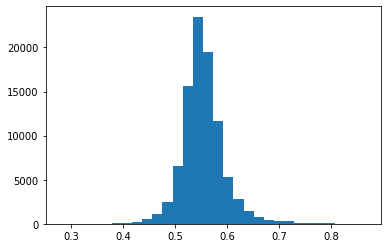

In [44]:
plt.hist(pred2, bins=30)

In [45]:
long = df_pred2.shape[1] / 10 * 7
short = df_pred2.shape[1] / 10 * 3

df_pred_rank2 = df_pred2.rank(axis=1)

df_pred_long2 = (df_pred_rank2 > long).astype(np.float32)
df_pred_short2 = (df_pred_rank2 < short).astype(np.float32)
df_pred_long_short2 = df_pred_long2 - df_pred_short2

In [46]:
strategy2 = EquityStrategy(strategy_name="EPM", asset_type="EQUITY")
strategy2.load_index_and_return(from_db=False, save_file=False)

strategy2.index.columns.name = 'ticker'
strategy2.ret.columns.name = 'ticker'

strategy2.index.index.name = 'tdate'
strategy2.ret.index.name = 'tdate'

strategy2.index.drop_duplicates(inplace=True)
strategy2.ret.drop_duplicates(inplace=True)

strategy2.ret.loc['2005-02-16'] = strategy2.ret.loc['2005-02-17']

2019-10-31 08:58:54,875 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-31 08:58:54,875 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-31 08:58:54,877 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-31 08:58:54,877 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-31 08:58:54,878 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-31 08:58:54,878 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [47]:
strategy2.TSRV = df_pred_long_short2
strategy2.CSRV = df_pred_long_short2

strategy2.set_rebalance_period(freq='week', rebalance_weekday=1) 
strategy2.set_portfolio_parameter(cs_strategy_type='notional')
strategy2.make_portfolio()

2019-10-31 08:58:54,952 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 08:58:54,952 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 08:58:54,953 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 08:58:54,953 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 08:58:54,955 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 08:58:54,955 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 08:58:54,956 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-31 08:58:54,956 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-31 08:59:15,122 - EPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-31 08:59:15,122 - EPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-31 08:59:15,123 - EPM - INFO - [STEP 5 - 2 - 1] ALIGN TS POSITION WITH REBALANCE DAY
2019-10-31 08:59:15,123 - EPM - INFO - [STEP 5 - 2 - 1] ALIGN TS POSITION WITH REBALANCE DAY
2019-10-31 08:59:17,624 - EPM - INFO - [STEP 5 - 2 - 2] TARGET VOL CONTROL to TS POSITION
2019-10-31 08:59:17,624 - EPM - 

### TRAIN

2019-10-31 08:59:29,044 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-31 08:59:29,044 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-31 08:59:29,045 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-31 08:59:29,045 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-31 08:59:29,052 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-31 08:59:29,052 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-31 08:59:29,060 - EPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-31 08:59:29,060 - EPM - INFO - [STEP 7] PLOT BACKTEST RESULT


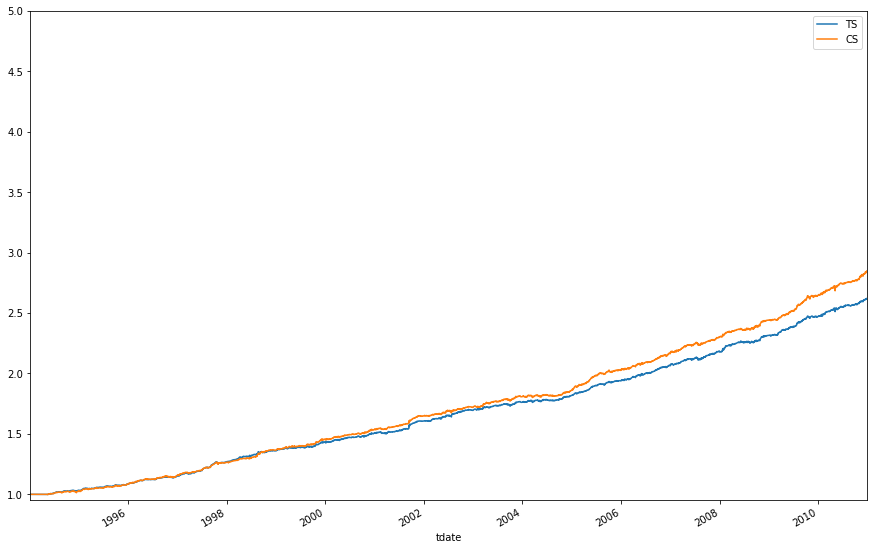

In [48]:
tester = Tester(strategy2)
tester.set_period(start='1994-01-01', end='2010-12-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.95, 5))

### TEST

2019-10-31 08:59:29,245 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-31 08:59:29,245 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-31 08:59:29,246 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-31 08:59:29,246 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-31 08:59:29,254 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-31 08:59:29,254 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-31 08:59:29,261 - EPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-31 08:59:29,261 - EPM - INFO - [STEP 7] PLOT BACKTEST RESULT


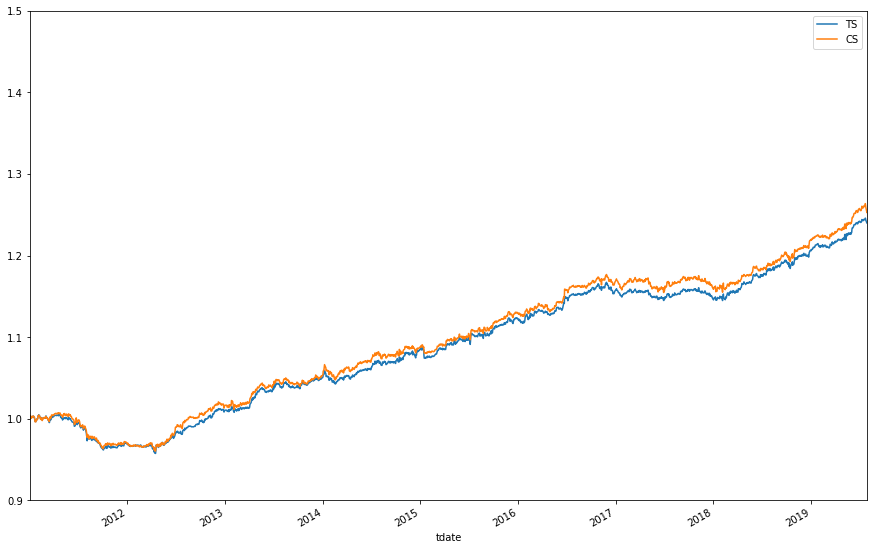

In [49]:
tester = Tester(strategy2)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False,  ylim=(0.9, 1.5))

# CASE 3. Case1을 Rolling으로 실행

In [50]:
rolling_one_year = ['2010-12-31',
                    '2011-12-31',
                    '2012-12-31',
                    '2013-12-31',
                    '2014-12-31',
                    '2015-12-31',
                    '2016-12-31',
                    '2017-12-31',
                    '2018-12-31']

In [51]:
def train(train_x, train_y1, val_x, val_y1, num_boost_round=1000, learning_rate=0.01, early_stopping_rounds=50, verbose=None):
    params1 = {"objective": "binary",
          "boosting_type": "gbdt",
          "num_boost_round": num_boost_round,
          'max_depth': 3,
          'num_leaves': 25,
          "learning_rate": learning_rate,
          "feature_fraction": 0.8,
          "subsample": 0.8,
          "verbosity": 1,
          "metric": 'binary_logloss'
          }              
    
    train_data = lgb.Dataset(train_x, train_y1)
    val_data = lgb.Dataset(val_x, val_y1)
    lgb_model = lgb.train(train_set=train_data, params=params1, early_stopping_rounds=early_stopping_rounds,
                          valid_sets=[train_data, val_data], verbose_eval=verbose)
    
    train_pred = lgb_model.predict(train_x)
    val_pred = lgb_model.predict(val_x)
    return lgb_model, train_pred, val_pred

In [52]:
models = []
train_preds = []
test_preds = []

In [53]:
for i, one_year in enumerate(rolling_one_year):
    df_train = df_join.loc[df_join['tdate'] <= pd.to_datetime(rolling_one_year[i])]
    
    if i == len(rolling_one_year) - 1:
        df_test = df_join.loc[df_join['tdate'] > pd.to_datetime(rolling_one_year[i])]
    else:
        df_test = df_join.loc[(df_join['tdate'] <= pd.to_datetime(rolling_one_year[i+1])) & 
                              (df_join['tdate'] > pd.to_datetime(rolling_one_year[i]))]

    df_train_y = df_train['y']
    df_train_x = df_train[df_train.columns[3:]]

    df_test_y = df_test['y']
    df_test_x = df_test[df_test.columns[3:]]
    
    model, train_pred, test_pred = train(df_train_x.values, df_train_y.values, df_test_x.values, df_test_y.values, 
                                        num_boost_round=500, 
                                        learning_rate=0.01, 
                                        verbose=10,
                                        early_stopping_rounds=500)
    
    df_train['y_pred'] = train_pred
    df_test['y_pred'] = test_pred
    
    models.append(model)
    train_preds.append(df_train)
    test_preds.append(df_test)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.692719	valid_1's binary_logloss: 0.692902
[20]	training's binary_logloss: 0.692355	valid_1's binary_logloss: 0.69272
[30]	training's binary_logloss: 0.692039	valid_1's binary_logloss: 0.692595
[40]	training's binary_logloss: 0.691747	valid_1's binary_logloss: 0.692563
[50]	training's binary_logloss: 0.691478	valid_1's binary_logloss: 0.692497
[60]	training's binary_logloss: 0.691226	valid_1's binary_logloss: 0.692519
[70]	training's binary_logloss: 0.691003	valid_1's binary_logloss: 0.692553
[80]	training's binary_logloss: 0.690788	valid_1's binary_logloss: 0.692541
[90]	training's binary_logloss: 0.690596	valid_1's binary_logloss: 0.692505
[100]	training's binary_logloss: 0.690414	valid_1's binary_logloss: 0.692471
[110]	training's binary_logloss: 0.690236	valid_1's binary_logloss: 0.692462
[120]	training's binary_logloss: 0.690077	valid_1's binary_logloss: 0.692511
[130]	training's binary_

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.692742	valid_1's binary_logloss: 0.692865
[20]	training's binary_logloss: 0.692401	valid_1's binary_logloss: 0.692609
[30]	training's binary_logloss: 0.692107	valid_1's binary_logloss: 0.692356
[40]	training's binary_logloss: 0.691839	valid_1's binary_logloss: 0.692124
[50]	training's binary_logloss: 0.691587	valid_1's binary_logloss: 0.691892
[60]	training's binary_logloss: 0.691358	valid_1's binary_logloss: 0.691738
[70]	training's binary_logloss: 0.691145	valid_1's binary_logloss: 0.691578
[80]	training's binary_logloss: 0.690942	valid_1's binary_logloss: 0.691471
[90]	training's binary_logloss: 0.690758	valid_1's binary_logloss: 0.691381
[100]	training's binary_logloss: 0.690572	valid_1's binary_logloss: 0.69133
[110]	training's binary_logloss: 0.690401	valid_1's binary_logloss: 0.691279
[120]	training's binary_logloss: 0.690239	valid_1's binary_logloss: 0.691184
[130]	training's binary_

[70]	training's binary_logloss: 0.691199	valid_1's binary_logloss: 0.692278
[80]	training's binary_logloss: 0.69101	valid_1's binary_logloss: 0.692234
[90]	training's binary_logloss: 0.690839	valid_1's binary_logloss: 0.692185
[100]	training's binary_logloss: 0.690671	valid_1's binary_logloss: 0.692146
[110]	training's binary_logloss: 0.69051	valid_1's binary_logloss: 0.692141
[120]	training's binary_logloss: 0.690351	valid_1's binary_logloss: 0.692123
[130]	training's binary_logloss: 0.690186	valid_1's binary_logloss: 0.692129
[140]	training's binary_logloss: 0.690035	valid_1's binary_logloss: 0.692128
[150]	training's binary_logloss: 0.689893	valid_1's binary_logloss: 0.692126
[160]	training's binary_logloss: 0.689759	valid_1's binary_logloss: 0.692109
[170]	training's binary_logloss: 0.689625	valid_1's binary_logloss: 0.692115
[180]	training's binary_logloss: 0.689499	valid_1's binary_logloss: 0.692106
[190]	training's binary_logloss: 0.68937	valid_1's binary_logloss: 0.692098
[200]

[140]	training's binary_logloss: 0.690203	valid_1's binary_logloss: 0.691563
[150]	training's binary_logloss: 0.690078	valid_1's binary_logloss: 0.691515
[160]	training's binary_logloss: 0.68995	valid_1's binary_logloss: 0.69147
[170]	training's binary_logloss: 0.689821	valid_1's binary_logloss: 0.691443
[180]	training's binary_logloss: 0.689699	valid_1's binary_logloss: 0.691428
[190]	training's binary_logloss: 0.689568	valid_1's binary_logloss: 0.691386
[200]	training's binary_logloss: 0.68945	valid_1's binary_logloss: 0.691357
[210]	training's binary_logloss: 0.68933	valid_1's binary_logloss: 0.691326
[220]	training's binary_logloss: 0.689207	valid_1's binary_logloss: 0.691341
[230]	training's binary_logloss: 0.689086	valid_1's binary_logloss: 0.69133
[240]	training's binary_logloss: 0.688958	valid_1's binary_logloss: 0.6914
[250]	training's binary_logloss: 0.688848	valid_1's binary_logloss: 0.691394
[260]	training's binary_logloss: 0.688744	valid_1's binary_logloss: 0.691407
[270]	

[190]	training's binary_logloss: 0.68984	valid_1's binary_logloss: 0.691368
[200]	training's binary_logloss: 0.68973	valid_1's binary_logloss: 0.691303
[210]	training's binary_logloss: 0.689623	valid_1's binary_logloss: 0.691235
[220]	training's binary_logloss: 0.689521	valid_1's binary_logloss: 0.691139
[230]	training's binary_logloss: 0.689421	valid_1's binary_logloss: 0.691068
[240]	training's binary_logloss: 0.689326	valid_1's binary_logloss: 0.691004
[250]	training's binary_logloss: 0.68923	valid_1's binary_logloss: 0.690947
[260]	training's binary_logloss: 0.689139	valid_1's binary_logloss: 0.690884
[270]	training's binary_logloss: 0.689043	valid_1's binary_logloss: 0.690832
[280]	training's binary_logloss: 0.688954	valid_1's binary_logloss: 0.690793
[290]	training's binary_logloss: 0.688862	valid_1's binary_logloss: 0.690762
[300]	training's binary_logloss: 0.68878	valid_1's binary_logloss: 0.690747
[310]	training's binary_logloss: 0.688694	valid_1's binary_logloss: 0.690716
[32

In [54]:
df_test_concat = pd.concat(test_preds, axis=0)
df_test_pred = pd.pivot_table(df_test_concat, columns='ticker', index='tdate', values='y_pred')

(array([1.000e+00, 3.000e+00, 7.000e+00, 9.000e+00, 1.200e+01, 2.400e+01,
        3.800e+01, 1.050e+02, 3.040e+02, 1.032e+03, 3.649e+03, 6.947e+03,
        9.081e+03, 5.972e+03, 2.320e+03, 9.070e+02, 4.010e+02, 1.780e+02,
        1.090e+02, 7.000e+01, 3.700e+01, 3.300e+01, 2.100e+01, 1.500e+01,
        8.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 2.000e+00]),
 array([0.31795108, 0.33230767, 0.34666425, 0.36102084, 0.37537743,
        0.38973401, 0.4040906 , 0.41844718, 0.43280377, 0.44716036,
        0.46151694, 0.47587353, 0.49023012, 0.5045867 , 0.51894329,
        0.53329987, 0.54765646, 0.56201305, 0.57636963, 0.59072622,
        0.60508281, 0.61943939, 0.63379598, 0.64815256, 0.66250915,
        0.67686574, 0.69122232, 0.70557891, 0.7199355 , 0.73429208,
        0.74864867]),
 <a list of 30 Patch objects>)

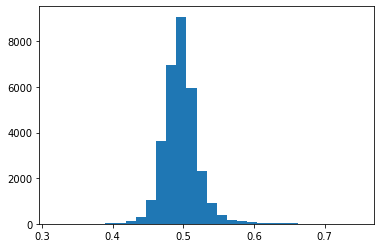

In [55]:
plt.hist(df_test_concat['y_pred'], bins=30)

In [56]:
long = df_test_pred.shape[1] / 10 * 7
short = df_test_pred.shape[1] / 10 * 3

df_pred_rank3 = df_test_pred.rank(axis=1)
df_pred_long3 = (df_pred_rank3 > long).astype(np.float32)
df_pred_short3 = (df_pred_rank3 < short).astype(np.float32)
df_pred_long_short3 = df_pred_long3 - df_pred_short3

In [57]:
strategy3 = EquityStrategy(strategy_name="EPM", asset_type="EQUITY")
strategy3.load_index_and_return(from_db=False, save_file=False)

strategy3.index.columns.name = 'ticker'
strategy3.ret.columns.name = 'ticker'

strategy3.index.index.name = 'tdate'
strategy3.ret.index.name = 'tdate'

strategy3.index.drop_duplicates(inplace=True)
strategy3.ret.drop_duplicates(inplace=True)

strategy3.ret.loc['2005-02-16'] = strategy3.ret.loc['2005-02-17']

2019-10-31 08:59:44,996 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-31 08:59:44,996 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-31 08:59:44,996 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-31 08:59:44,998 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-31 08:59:44,998 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-31 08:59:44,998 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-31 08:59:45,000 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-31 08:59:45,000 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-31 08:59:45,000 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [58]:
strategy3.TSRV = df_pred_long_short3
strategy3.CSRV = df_pred_long_short3

strategy3.set_rebalance_period(freq='week', rebalance_weekday=1) 
strategy3.set_portfolio_parameter(cs_strategy_type='notional')
strategy3.make_portfolio()

2019-10-31 08:59:45,046 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 08:59:45,046 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 08:59:45,046 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 08:59:45,047 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 08:59:45,047 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 08:59:45,047 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 08:59:45,048 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 08:59:45,048 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 08:59:45,048 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 08:59:45,049 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-31 08:59:45,049 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-31 08:59:45,049 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-31 09:00:00,265 - EPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-31 09:00:00,265 - EPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-31 09:00:00,265 - EPM -

2019-10-31 09:00:04,587 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:00:04,587 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:00:04,587 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:00:04,588 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-31 09:00:04,588 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-31 09:00:04,588 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-31 09:00:04,596 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-31 09:00:04,596 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-31 09:00:04,596 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-31 09:00:04,604 - EPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-31 09:00:04,604 - EPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-31 09:00:04,604 - EPM - INFO - [STEP 7] PLOT BACKTEST RESULT


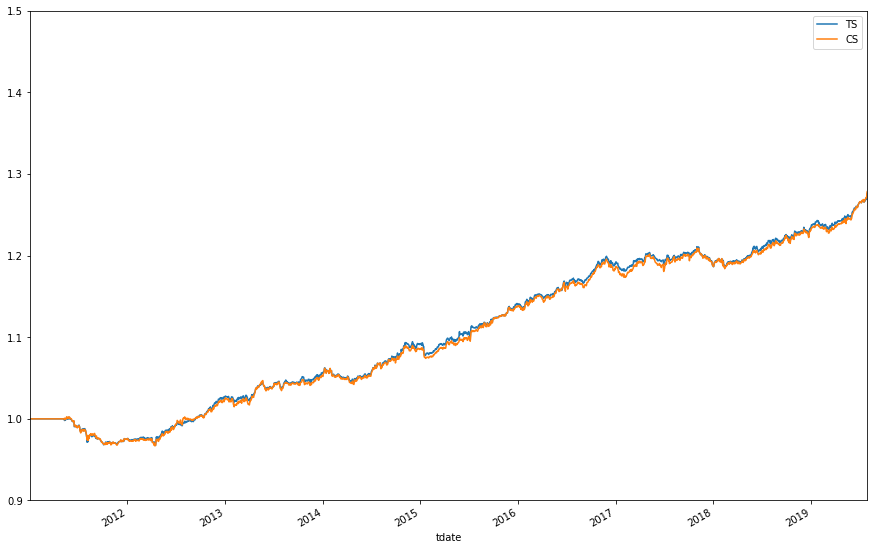

In [59]:
tester = Tester(strategy3)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.9, 1.5))

# CASE 4. CASE 2를 ROLLING으로 실행

In [60]:
models = []
train_preds = []
test_preds = []

In [61]:
for i, one_year in enumerate(rolling_one_year):
    df_train = df_join2.loc[df_join2['tdate'] <= pd.to_datetime(rolling_one_year[i])]
    
    if i == len(rolling_one_year) - 1:
        df_test = df_join.loc[df_join['tdate'] > pd.to_datetime(rolling_one_year[i])]
    else:
        df_test = df_join.loc[(df_join['tdate'] <= pd.to_datetime(rolling_one_year[i+1])) & 
                              (df_join['tdate'] > pd.to_datetime(rolling_one_year[i]))]

    df_train_y = df_train['y']
    df_train_x = df_train[df_train.columns[3:]]

    df_test_y = df_test['y']
    df_test_x = df_test[df_test.columns[3:]]
    
    model, train_pred, test_pred = train(df_train_x.values, df_train_y.values, df_test_x.values, df_test_y.values, 
                                        num_boost_round=500, 
                                        learning_rate=0.01, 
                                        verbose=10,
                                        early_stopping_rounds=500)
    
    df_train['y_pred'] = train_pred
    df_test['y_pred'] = test_pred
    
    models.append(model)
    train_preds.append(df_train)
    test_preds.append(df_test)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.68621	valid_1's binary_logloss: 0.699796
[20]	training's binary_logloss: 0.685542	valid_1's binary_logloss: 0.699873
[30]	training's binary_logloss: 0.684965	valid_1's binary_logloss: 0.700222
[40]	training's binary_logloss: 0.684453	valid_1's binary_logloss: 0.700497
[50]	training's binary_logloss: 0.683999	valid_1's binary_logloss: 0.700912
[60]	training's binary_logloss: 0.683579	valid_1's binary_logloss: 0.70117
[70]	training's binary_logloss: 0.683192	valid_1's binary_logloss: 0.701537
[80]	training's binary_logloss: 0.682835	valid_1's binary_logloss: 0.70179
[90]	training's binary_logloss: 0.682516	valid_1's binary_logloss: 0.702871
[100]	training's binary_logloss: 0.682209	valid_1's binary_logloss: 0.704088
[110]	training's binary_logloss: 0.681942	valid_1's binary_logloss: 0.705612
[120]	training's binary_logloss: 0.681664	valid_1's binary_logloss: 0.70663
[130]	training's binary_log

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.686227	valid_1's binary_logloss: 0.698792
[20]	training's binary_logloss: 0.685586	valid_1's binary_logloss: 0.698016
[30]	training's binary_logloss: 0.685025	valid_1's binary_logloss: 0.697563
[40]	training's binary_logloss: 0.684523	valid_1's binary_logloss: 0.697363
[50]	training's binary_logloss: 0.684073	valid_1's binary_logloss: 0.697102
[60]	training's binary_logloss: 0.683668	valid_1's binary_logloss: 0.697165
[70]	training's binary_logloss: 0.683307	valid_1's binary_logloss: 0.697087
[80]	training's binary_logloss: 0.68297	valid_1's binary_logloss: 0.697795
[90]	training's binary_logloss: 0.682662	valid_1's binary_logloss: 0.698703
[100]	training's binary_logloss: 0.682377	valid_1's binary_logloss: 0.699301
[110]	training's binary_logloss: 0.682106	valid_1's binary_logloss: 0.700059
[120]	training's binary_logloss: 0.681838	valid_1's binary_logloss: 0.701822
[130]	training's binary_

[110]	training's binary_logloss: 0.682236	valid_1's binary_logloss: 0.700945
[120]	training's binary_logloss: 0.681975	valid_1's binary_logloss: 0.702087
[130]	training's binary_logloss: 0.681725	valid_1's binary_logloss: 0.702503
[140]	training's binary_logloss: 0.681509	valid_1's binary_logloss: 0.702844
[150]	training's binary_logloss: 0.681292	valid_1's binary_logloss: 0.703573
[160]	training's binary_logloss: 0.681077	valid_1's binary_logloss: 0.704141
[170]	training's binary_logloss: 0.680872	valid_1's binary_logloss: 0.704923
[180]	training's binary_logloss: 0.680654	valid_1's binary_logloss: 0.705736
[190]	training's binary_logloss: 0.680449	valid_1's binary_logloss: 0.707346
[200]	training's binary_logloss: 0.680246	valid_1's binary_logloss: 0.707958
[210]	training's binary_logloss: 0.680052	valid_1's binary_logloss: 0.709305
[220]	training's binary_logloss: 0.679864	valid_1's binary_logloss: 0.710258
[230]	training's binary_logloss: 0.679686	valid_1's binary_logloss: 0.710811

[190]	training's binary_logloss: 0.680698	valid_1's binary_logloss: 0.708536
[200]	training's binary_logloss: 0.680486	valid_1's binary_logloss: 0.709697
[210]	training's binary_logloss: 0.680296	valid_1's binary_logloss: 0.711516
[220]	training's binary_logloss: 0.6801	valid_1's binary_logloss: 0.713363
[230]	training's binary_logloss: 0.679921	valid_1's binary_logloss: 0.715138
[240]	training's binary_logloss: 0.679736	valid_1's binary_logloss: 0.716559
[250]	training's binary_logloss: 0.679565	valid_1's binary_logloss: 0.718264
[260]	training's binary_logloss: 0.679383	valid_1's binary_logloss: 0.719499
[270]	training's binary_logloss: 0.679226	valid_1's binary_logloss: 0.720418
[280]	training's binary_logloss: 0.679076	valid_1's binary_logloss: 0.721554
[290]	training's binary_logloss: 0.678916	valid_1's binary_logloss: 0.722482
[300]	training's binary_logloss: 0.678765	valid_1's binary_logloss: 0.723792
[310]	training's binary_logloss: 0.678606	valid_1's binary_logloss: 0.724722
[

[280]	training's binary_logloss: 0.679496	valid_1's binary_logloss: 0.721829
[290]	training's binary_logloss: 0.679339	valid_1's binary_logloss: 0.722441
[300]	training's binary_logloss: 0.679205	valid_1's binary_logloss: 0.723026
[310]	training's binary_logloss: 0.679064	valid_1's binary_logloss: 0.724294
[320]	training's binary_logloss: 0.678909	valid_1's binary_logloss: 0.724531
[330]	training's binary_logloss: 0.678748	valid_1's binary_logloss: 0.725542
[340]	training's binary_logloss: 0.678613	valid_1's binary_logloss: 0.726053
[350]	training's binary_logloss: 0.678471	valid_1's binary_logloss: 0.726626
[360]	training's binary_logloss: 0.678315	valid_1's binary_logloss: 0.726576
[370]	training's binary_logloss: 0.678173	valid_1's binary_logloss: 0.727317
[380]	training's binary_logloss: 0.67804	valid_1's binary_logloss: 0.728304
[390]	training's binary_logloss: 0.677897	valid_1's binary_logloss: 0.729301
[400]	training's binary_logloss: 0.677742	valid_1's binary_logloss: 0.729625


In [62]:
df_test_concat = pd.concat(test_preds, axis=0)
df_test_pred = pd.pivot_table(df_test_concat, columns='ticker', index='tdate', values='y_pred')

long = df_test_pred.shape[1] / 10 * 7
short = df_test_pred.shape[1] / 10 * 3

In [63]:
df_pred_rank4 = df_test_pred.rank(axis=1)
df_pred_long4 = (df_pred_rank4 > long).astype(np.float32)
df_pred_short4 = (df_pred_rank4 < short).astype(np.float32)
df_pred_long_short4 = df_pred_long4 - df_pred_short4

In [64]:
strategy4 = EquityStrategy(strategy_name="EPM", asset_type="EQUITY")
strategy4.load_index_and_return(from_db=False, save_file=False)

strategy4.index.columns.name = 'ticker'
strategy4.ret.columns.name = 'ticker'

strategy4.index.index.name = 'tdate'
strategy4.ret.index.name = 'tdate'

strategy4.index.drop_duplicates(inplace=True)
strategy4.ret.drop_duplicates(inplace=True)

strategy4.ret.loc['2005-02-16'] = strategy4.ret.loc['2005-02-17']

2019-10-31 09:00:15,667 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-31 09:00:15,667 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-31 09:00:15,667 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-31 09:00:15,667 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-31 09:00:15,670 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:00:15,670 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:00:15,670 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:00:15,670 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-31 09:00:15,672 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-31 09:00:15,672 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-31 09:00:15,672 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-31 09:00:15,672 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [65]:
strategy4.TSRV = df_pred_long_short4
strategy4.CSRV = df_pred_long_short4

strategy4.set_rebalance_period(freq='week', rebalance_weekday=1) 
strategy4.set_portfolio_parameter(cs_strategy_type='notional')
strategy4.make_portfolio()

2019-10-31 09:00:15,720 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:00:15,720 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:00:15,720 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:00:15,720 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 09:00:15,721 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:00:15,721 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:00:15,721 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:00:15,721 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 09:00:15,723 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 09:00:15,723 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 09:00:15,723 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 09:00:15,723 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 09:00:15,724 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-31 09:00:15,724 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-31 09:00:15,724 - EPM - INFO -

2019-10-31 09:00:40,422 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:00:40,422 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:00:40,422 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:00:40,422 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-31 09:00:40,425 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-31 09:00:40,425 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-31 09:00:40,425 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-31 09:00:40,425 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-31 09:00:40,437 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-31 09:00:40,437 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-31 09:00:40,437 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-31 09:00:40,437 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-31 09:00:40,449 - EPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-31 09:00:40,449 - EPM - INFO - [STEP 7]

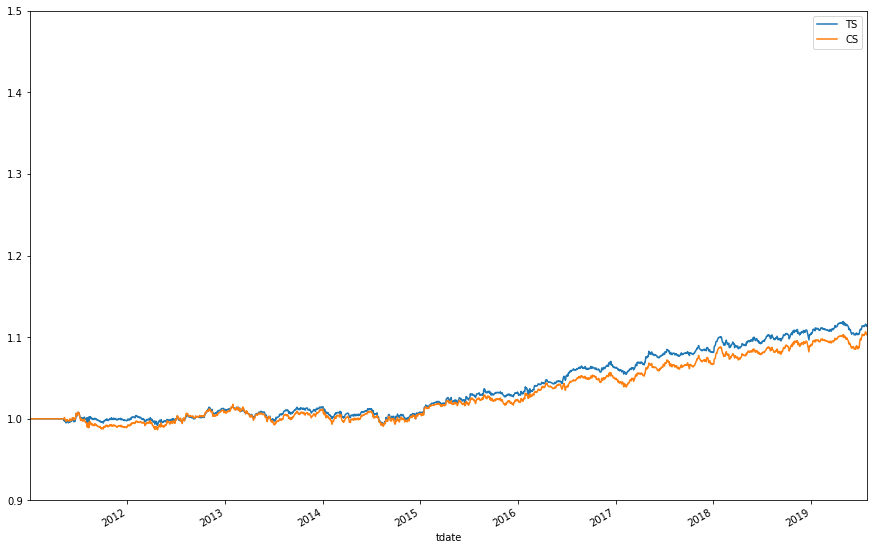

In [66]:
tester = Tester(strategy4)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False,  ylim=(0.9, 1.5))